In [2]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sklearn.set_config(transform_output="pandas")
from tensorflow import keras

# tf.debugging.set_log_device_placement(True)

2023-09-19 13:38:27.554280: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-19 13:38:27.598028: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-19 13:38:28.344558: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
from sklearn.base import BaseEstimator, TransformerMixin


class LibraryLengthNormalizer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Normalise the gene counts to the library size
        X = X.apply(lambda x: (x / (x.sum() if x.sum() != 0 else 1)) * 1000000)
        return X


class DataNormalizerDESeq2(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Ensure all values are non-negative
        data = X.applymap(lambda x: max(x, 0))

        # Take the log
        log_data = np.log1p(data)

        # Calculate the pseudo-reference sample for each gene
        log_data["pseudo_reference"] = log_data.mean(axis=1)

        # Filter out genes with -Inf as their average
        filtered_log_data = log_data[log_data["pseudo_reference"] != float("-inf")]

        # Subtract the gene pseudo-references from log counts
        ratio_data = filtered_log_data.iloc[:, :-1].sub(
            filtered_log_data["pseudo_reference"], axis=0
        )

        # Find the median of the ratios for each sample
        sample_medians = ratio_data.median(axis=0)

        # Convert medians to scaling factors
        scaling_factors = np.exp(sample_medians)

        # Divide the original counts by the scaling factors
        X = data.div(scaling_factors)

        return X

In [9]:
file_name = "gene_counts_NN_55_training.csv"

data = pd.read_csv(file_name)
data_features = data.drop(columns=["sample"])
target = data["sample"]

In [24]:
from sklearn.model_selection import train_test_split

split_params = {
    "test_size": 0.2,
    "random_state": 0,
    "shuffle": True,
}


X_train, X_test, y_train, y_test = train_test_split(
    data_features,
    target,
    **split_params,
    stratify=target,
)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder


label_transformer = LabelEncoder()

y_train = label_transformer.fit_transform(y_train)
y_test = label_transformer.transform(y_test)

In [26]:
from feature_engine.selection import DropConstantFeatures


feature_transformer = Pipeline(
    [
        ("constant_feature_drop", DropConstantFeatures(tol=0.50)),
        ("normalise_for_library_size", LibraryLengthNormalizer()),
    ]
)
print("Number of variables before: ", X_train.shape[1])

X_train = feature_transformer.fit_transform(X_train)
X_test = feature_transformer.transform(X_test)

print("Number of variables after: ", X_train.shape[1])

Number of variables before:  19992
Number of variables after:  14601


## 2. Simple SVC OVO model training 

In [10]:
keras.backend.clear_session()
keras.utils.set_random_seed(2)

In [8]:
# SVM for multi-class classification using built-in one-vs-one
from sklearn.svm import SVC

# define model
svc = SVC(decision_function_shape="ovo")
# fit model
svc.fit(X_train, y_train)

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(decision_function_shape='ovo')

In [9]:
# make predictions
y_pred = svc.predict(X_test)

In [39]:
from sklearn import metrics

statistics_dict = {}


def evaluate_model(name, real_labels, predicted_labels):
    accuracy, precision, recall, specificity, f1_score, confusion_matrix = (
        metrics.accuracy_score(real_labels, predicted_labels),
        metrics.precision_score(
            real_labels, predicted_labels, average="macro", zero_division=0
        ),
        metrics.recall_score(real_labels, predicted_labels, average="macro"),
        metrics.recall_score(real_labels, predicted_labels, average="macro"),
        metrics.f1_score(real_labels, predicted_labels, average="macro"),
        metrics.confusion_matrix(real_labels, predicted_labels),
    )
    statistics_dict[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "Specificity": specificity,
        "F1 Score": f1_score,
        "Confusion Matrix": confusion_matrix,
    }
    return statistics_dict

In [11]:
evaluate_model("binary SVC classifier", y_test, y_pred)

{'binary SVC classifier': {'Accuracy': 0.2727272727272727,
  'Precision': 0.14814814814814814,
  'Recall': 0.16666666666666666,
  'Specificity': 0.16666666666666666,
  'F1 Score': 0.12962962962962962,
  'Confusion Matrix': array([[0, 0, 0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 0, 1, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 0, 1, 0, 0, 0, 0],
         [0, 0, 0, 0, 2, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 0, 1, 0, 0],
         [0, 0, 0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 0, 0, 1, 0, 0, 0]])}}

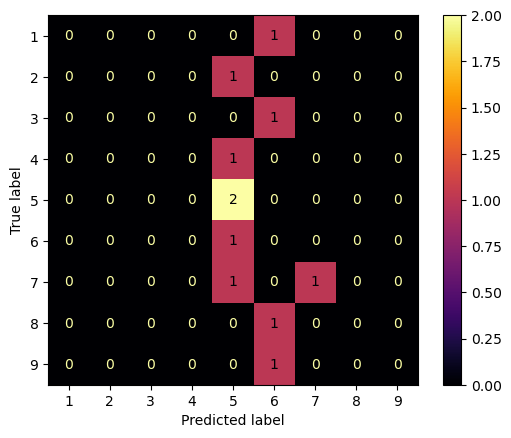

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(svc, X_test, y_test, cmap="inferno")

In [ ]:
# SVM for multi-class classification using built-in one-vs-one
from sklearn.svm import SVC

# define model
svc = SVC(decision_function_shape="ovo")
# fit model
svc.fit(X_train, y_train)

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(decision_function_shape='ovo')

In [ ]:
# make predictions
y_pred = svc.predict(X_test)

In [ ]:
from sklearn import metrics

statistics_dict = {}


def evaluate_model(name, real_labels, predicted_labels):
    accuracy, precision, recall, specificity, f1_score, confusion_matrix = (
        metrics.accuracy_score(real_labels, predicted_labels),
        metrics.precision_score(
            real_labels, predicted_labels, average="macro", zero_division=0
        ),
        metrics.recall_score(real_labels, predicted_labels, average="macro"),
        metrics.recall_score(real_labels, predicted_labels, average="macro"),
        metrics.f1_score(real_labels, predicted_labels, average="macro"),
        metrics.confusion_matrix(real_labels, predicted_labels),
    )
    statistics_dict[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "Specificity": specificity,
        "F1 Score": f1_score,
        "Confusion Matrix": confusion_matrix,
    }
    return statistics_dict

In [ ]:
evaluate_model("binary SVC classifier", y_test, y_pred)

{'binary SVC classifier': {'Accuracy': 0.2727272727272727,
  'Precision': 0.14814814814814814,
  'Recall': 0.16666666666666666,
  'Specificity': 0.16666666666666666,
  'F1 Score': 0.12962962962962962,
  'Confusion Matrix': array([[0, 0, 0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 0, 1, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 0, 1, 0, 0, 0, 0],
         [0, 0, 0, 0, 2, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 0, 1, 0, 0],
         [0, 0, 0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 0, 0, 1, 0, 0, 0]])}}

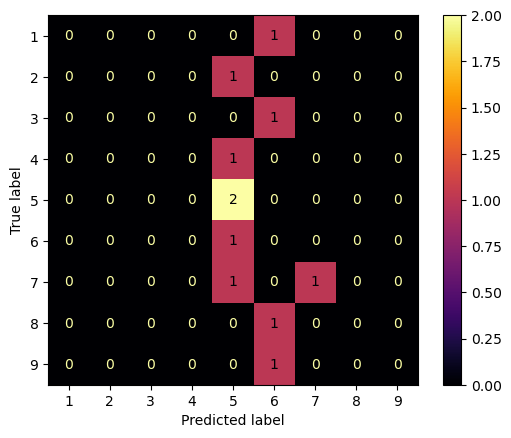

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(svc, X_test, y_test, cmap="inferno")

In [ ]:
# SVM for multi-class classification using built-in one-vs-one
from sklearn.svm import SVC

# define model
svc = SVC(decision_function_shape="ovo")
# fit model
svc.fit(X_train, y_train)

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(decision_function_shape='ovo')

In [ ]:
# make predictions
y_pred = svc.predict(X_test)

In [ ]:
from sklearn import metrics

statistics_dict = {}


def evaluate_model(name, real_labels, predicted_labels):
    accuracy, precision, recall, specificity, f1_score, confusion_matrix = (
        metrics.accuracy_score(real_labels, predicted_labels),
        metrics.precision_score(
            real_labels, predicted_labels, average="macro", zero_division=0
        ),
        metrics.recall_score(real_labels, predicted_labels, average="macro"),
        metrics.recall_score(real_labels, predicted_labels, average="macro"),
        metrics.f1_score(real_labels, predicted_labels, average="macro"),
        metrics.confusion_matrix(real_labels, predicted_labels),
    )
    statistics_dict[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "Specificity": specificity,
        "F1 Score": f1_score,
        "Confusion Matrix": confusion_matrix,
    }
    return statistics_dict

In [ ]:
evaluate_model("binary SVC classifier", y_test, y_pred)

{'binary SVC classifier': {'Accuracy': 0.2727272727272727,
  'Precision': 0.14814814814814814,
  'Recall': 0.16666666666666666,
  'Specificity': 0.16666666666666666,
  'F1 Score': 0.12962962962962962,
  'Confusion Matrix': array([[0, 0, 0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 0, 1, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 0, 1, 0, 0, 0, 0],
         [0, 0, 0, 0, 2, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 0, 1, 0, 0],
         [0, 0, 0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 0, 0, 1, 0, 0, 0]])}}

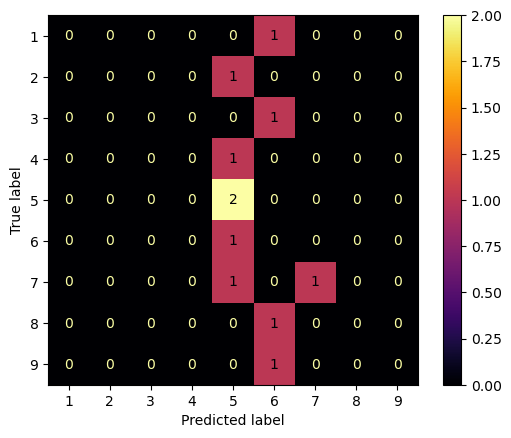

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(svc, X_test, y_test, cmap="inferno")

## 3. Binary classifier

In [16]:
from sklearn.svm import LinearSVC
import numpy as np

n_classes = 9
classifiers = []
for i in range(n_classes):
    # Create a binary classifier for the current class
    svc = LinearSVC(dual="auto")
    # Train the classifier on the positive samples of the current class and negative samples of all the other classes combined
    svc.fit(X_train, (y_train == i).astype(int))
    classifiers.append(svc)

# Use the trained binary classifiers to obtain decision values
decision_values = []
for clf in classifiers:
    decision_values.append(clf.decision_function(X_test))

# Combine decision values to make multi-class predictions
decision_values = np.array(decision_values).T
y_pred = np.argmax(decision_values, axis=1)

## 4. Binary classifier with selection of features


In [6]:
file_name = "gene_counts_NN_55_training.csv"

data = pd.read_csv(file_name)
data_features = data.drop(columns=["sample"])
target = data["sample"]

In [7]:
from sklearn.model_selection import train_test_split

split_params = {
    "test_size": 0.2,
    "random_state": 0,
    "shuffle": True,
}


X_train, X_test, y_train, y_test = train_test_split(
    data_features,
    target,
    **split_params,
    stratify=target,
)

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder


label_transformer = LabelEncoder()

y_train = label_transformer.fit_transform(y_train)
y_test = label_transformer.transform(y_test)

In [9]:
from sklearn.pipeline import Pipeline
from feature_engine.selection import (
    DropDuplicateFeatures,
    DropConstantFeatures,
    DropCorrelatedFeatures,
)


feature_transformer = Pipeline(
    [
        ("drop_duplicates", DropDuplicateFeatures()),
        ("constant_feature_drop", DropConstantFeatures(tol=0.50)),
        ("normalise_for_library_size", LibraryLengthNormalizer()),
        (
            "drop correlating features",
            DropCorrelatedFeatures(variables=None, method="pearson", threshold=0.8),
        ),
    ]
)
print("Number of features before: ", X_train.shape[1])

X_train = feature_transformer.fit_transform(X_train)
X_test = feature_transformer.transform(X_test)

print("Number of features after: ", X_train.shape[1])

Number of features before:  19992
Number of features after:  2127


In [11]:
# SVM for multi-class classification using built-in one-vs-one
from sklearn.svm import SVC

# define model
svc = SVC(decision_function_shape="ovo")
# fit model
svc.fit(X_train, y_train)

SVC(decision_function_shape='ovo')

In [12]:
# make predictions
y_pred = svc.predict(X_test)

In [13]:
from sklearn import metrics

statistics_dict = {}


def evaluate_model(name, real_labels, predicted_labels):
    accuracy, precision, recall, specificity, f1_score, confusion_matrix = (
        metrics.accuracy_score(real_labels, predicted_labels),
        metrics.precision_score(
            real_labels, predicted_labels, average="macro", zero_division=0
        ),
        metrics.recall_score(real_labels, predicted_labels, average="macro"),
        metrics.recall_score(real_labels, predicted_labels, average="macro"),
        metrics.f1_score(real_labels, predicted_labels, average="macro"),
        metrics.confusion_matrix(real_labels, predicted_labels),
    )
    statistics_dict[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "Specificity": specificity,
        "F1 Score": f1_score,
        "Confusion Matrix": confusion_matrix,
    }
    return statistics_dict

In [14]:
evaluate_model("binary SVC classifier", y_test, y_pred)

{'binary SVC classifier': {'Accuracy': 0.18181818181818182,
  'Precision': 0.020202020202020204,
  'Recall': 0.1111111111111111,
  'Specificity': 0.1111111111111111,
  'F1 Score': 0.03418803418803419,
  'Confusion Matrix': array([[0, 0, 0, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 2, 0, 0, 0, 0, 0],
         [0, 0, 0, 2, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0, 0, 0]])}}

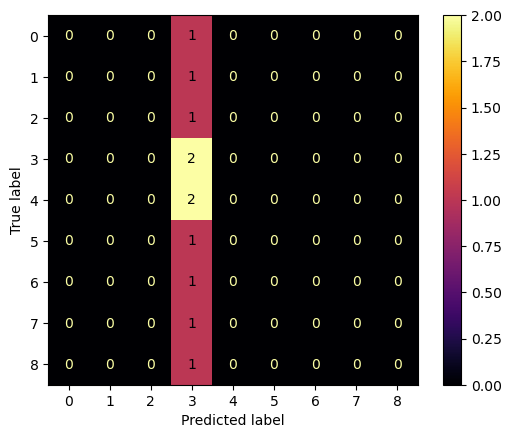

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(svc, X_test, y_test, cmap="inferno")

In [54]:
from sklearn.svm import LinearSVC
from sklearn.metrics import ConfusionMatrixDisplay

n_classes = 9
classifiers = []
for i in range(n_classes):
    # Create a binary classifier for the current class
    svc = SVC(kernel="linear", probability=True)
    # Train the classifier on the positive samples of the current class and negative samples of all the other classes combined
    svc.fit(X_train, (y_train == i).astype(int))

    classifiers.append(svc)

# Use the trained binary classifiers to obtain decision values
decision_values = []
for clf in classifiers:
    decision_values.append(clf.predict_proba(X_test))  # predict_proba decision_function

# # Combine decision values to make multi-class predictions
decision_values = np.array(decision_values).T
y_pred = np.argmax(decision_values, axis=1)

In [52]:
ConfusionMatrixDisplay.from_estimator(svc, X_test, y_test, cmap="inferno")